In [17]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import seaborn as sns
from joblib import dump

RANDOM_STATE = 42

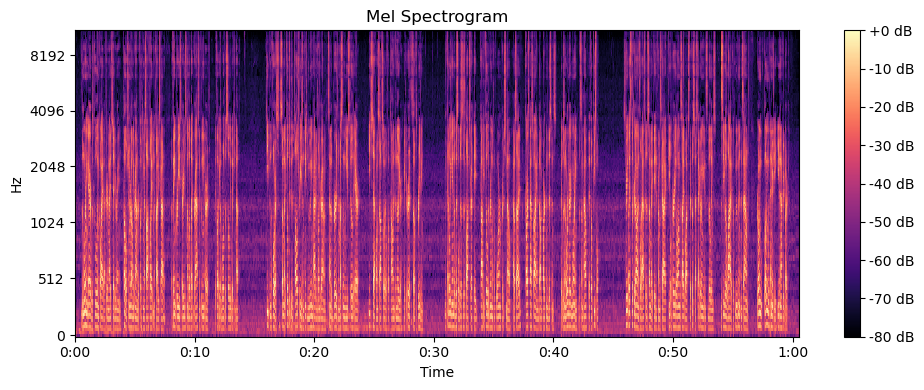

Traceback (most recent call last):
  File "/home/davb001/miniconda3/envs/machine_learning/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /loky-16434-44isrs8q for automatic cleanup: unknown resource type semlock
Traceback (most recent call last):
  File "/home/davb001/miniconda3/envs/machine_learning/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /loky-16434-el637eaf for automatic cleanup: unknown resource type semlock
Traceback (most recent call last):
  File "/home/davb001/miniconda3/envs/machine_learning/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic 

In [24]:
df = pd.read_csv("../data/audio/processed/audio_features.csv")

# cool visual for presenttion
y, sr = librosa.load("../data/audio/raw/m4a_recordings/Drake.wav", sr=22050)
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
S_db = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.tight_layout()
plt.show()

In [20]:
# slplit data into tain/testing + encode speaker names
x = df.drop(columns="speaker", axis=1)
y = df["speaker"]
y_encoded = df["speaker"].map({"Drake":0, "Melissa":1, "Lisa":2, "Dan":3, "David":4})
x_train, x_test, y_train, y_test = train_test_split(x, y_encoded, test_size=0.30, random_state=RANDOM_STATE)

Gradient Boosting:


Traceback (most recent call last):
  File "/home/davb001/miniconda3/envs/machine_learning/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /dev/shm/joblib_memmapping_folder_16434_2df34cc6bc8c4723ada4c667a167ac1f_3c787d54b3d649ad8460af5d0005f9ae for automatic cleanup: unknown resource type folder
Traceback (most recent call last):
  File "/home/davb001/miniconda3/envs/machine_learning/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /dev/shm/joblib_memmapping_folder_16434_4c7bbd263bf04f9a964b855165ce4539_ccb33f73f42442c2b37a99ef1c3f92ad for automatic cleanup: unknown resource type folder
Traceback (most recent call last):
  File "/home/davb001/minic

Best F1 Score: 0.9726380636123063
Best Params: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 2, 'classifier__n_estimators': 200, 'selector__k': 30}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        41
           1       0.95      1.00      0.97        36
           2       1.00      1.00      1.00        42
           3       1.00      0.94      0.97        31
           4       1.00      1.00      1.00        38

    accuracy                           0.99       188
   macro avg       0.99      0.99      0.99       188
weighted avg       0.99      0.99      0.99       188



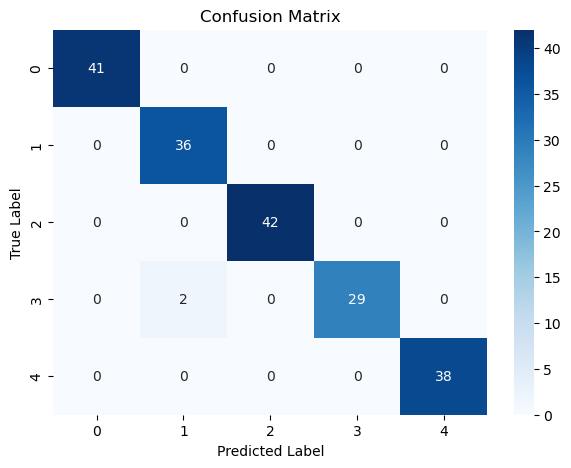

Selected Features:
Index(['mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7',
       'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13',
       'chroma_2', 'chroma_4', 'chroma_5', 'chroma_6', 'chroma_7', 'chroma_8',
       'chroma_9', 'chroma_10', 'chroma_11', 'contrast_1', 'contrast_3',
       'contrast_4', 'contrast_5', 'contrast_6', 'contrast_7', 'zcr', 'rms'],
      dtype='object')


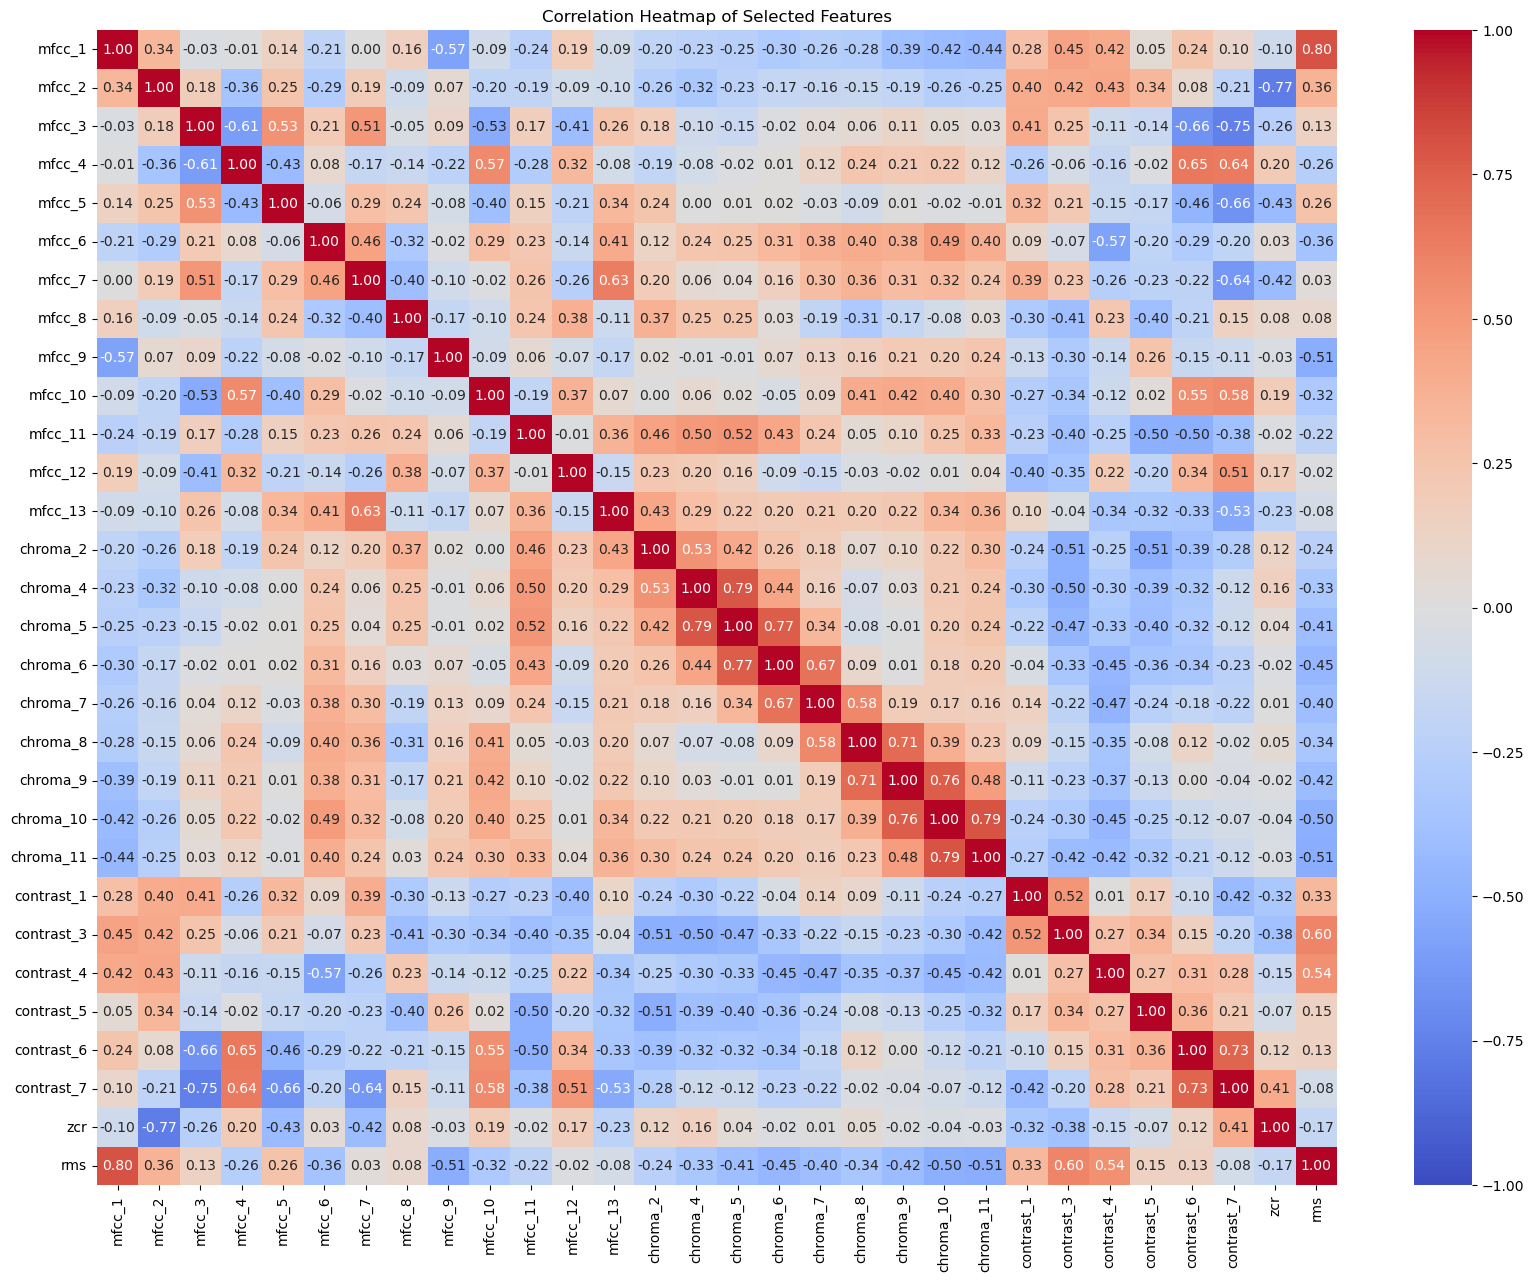

In [23]:
dt_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('selector', SelectKBest(mutual_info_classif, k=30)),
    ('classifier', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

dt_grid = {
    'selector__k': [20, 30],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__splitter': ['best', 'random']
}

rf_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('selector', SelectKBest(mutual_info_classif, k=30)),
    ('classifier', RandomForestClassifier(random_state=RANDOM_STATE))
])

rf_grid = {
    'selector__k': [20, 30],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2'],
}
    
gb_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('selector', SelectKBest(mutual_info_classif, k=30)),
    ('classifier', GradientBoostingClassifier(random_state=RANDOM_STATE))
])
    
gb_grid = {
    "selector__k": [20,30],
    "classifier__n_estimators": [100, 200],
    "classifier__learning_rate": [0.01, 0.05, 0.1],
    "classifier__max_depth": [2, 3]
}

# dt_search = GridSearchCV(dt_pipe, dt_grid, scoring="f1_macro", cv=5, n_jobs=-1)
# dt_search.fit(x_train, y_train)
# print("Decision Tree:")
# print(f"Best F1 Score: {dt_search.best_score_}")
# print(f"Best Params: {dt_search.best_params_}")

# rf_search = GridSearchCV(rf_pipe, rf_grid, scoring="f1_macro", cv=5, n_jobs=-1)
# rf_search.fit(x_train, y_train)
# print("Random Forest:")
# print(f"Best F1 Score: {rf_search.best_score_}")
# print(f"Best Params: {rf_search.best_params_}")

print("Gradient Boosting:")
gb_search = GridSearchCV(gb_pipe, gb_grid, scoring="f1_macro", cv=3, n_jobs=-1)
gb_search.fit(x_train, y_train)
print(f"Best F1 Score: {gb_search.best_score_}")
print(f"Best Params: {gb_search.best_params_}")

# best model
gb_model = gb_search.best_estimator_
y_pred = gb_model.predict(x_test)

# confusion matrix/metric report
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# selected features:
select_k_best = gb_search.best_estimator_.named_steps['selector']

# Get the selected features (indices)
selected_indices = select_k_best.get_support(indices=True)

# Map the indices back to the feature names (from X_train)
selected_features = x_train.columns[selected_indices]

print("Selected Features:")
print(selected_features)

selected_features_data = x_train[selected_features]

# Calculate the correlation matrix for selected features
correlation_matrix = selected_features_data.corr()

# Plot the correlation matrix
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title("Correlation Heatmap of Selected Features")
plt.show()

In [20]:
dump(gb_model, "speech_rec_model.pkl")

['speech_rec_model.pkl']

Traceback (most recent call last):
  File "/home/davb001/miniconda3/envs/machine_learning/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /loky-14001-r748hc8y for automatic cleanup: unknown resource type semlock
Traceback (most recent call last):
  File "/home/davb001/miniconda3/envs/machine_learning/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /loky-14001-amucct60 for automatic cleanup: unknown resource type semlock
Traceback (most recent call last):
  File "/home/davb001/miniconda3/envs/machine_learning/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic 